In [1]:
import torch
from unet import UNet
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from torch.utils.data import DataLoader, dataset, Dataset
import os
from pathlib import Path
import torch
import torch.optim as optim
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.metrics import f1_score
from unet import UNet
device = "cuda" if torch.cuda.is_available() else "cpu"

### UNet version1 test

In [2]:
generator = UNet( in_channels=3, out_channels=1)

In [3]:
generator.load_state_dict(torch.load('./model/unet.pt', map_location=torch.device('cpu')))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8048\3188692937.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('./model/unet.pt', map_

<All keys matched successfully>

In [4]:
class CellDataset(Dataset):
    def __init__(self, image_folder, mask_folder, transform_image, transform_mask):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = sorted(os.listdir(image_folder))  # Sorted to match image and mask pairs
        self.mask_files = sorted(os.listdir(mask_folder))  # Sorted to match image and mask pairs
        self.transform_image = transform_image
        self.transform_mask = transform_mask

        # Ensure the filenames of images and masks match
        for img, mask in zip(self.image_files, self.mask_files):
            if img.split('.')[0].split('_')[-1] != mask.split('.')[0].split('_')[-1]:
                raise ValueError(f"Mismatch between image and mask filenames: {img}, {mask}")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.mask_folder, self.mask_files[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Grayscale mask for binary segmentation

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask


image_folder = "./data/images"
mask_folder = "./data/masks"

transform_image = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize RGB values
])

transform_mask = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Grayscale()  # Convert to 1-channel (binary) mask
])



dataset = CellDataset(image_folder, mask_folder, transform_image, transform_mask)
cell_loader = DataLoader(dataset, batch_size=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


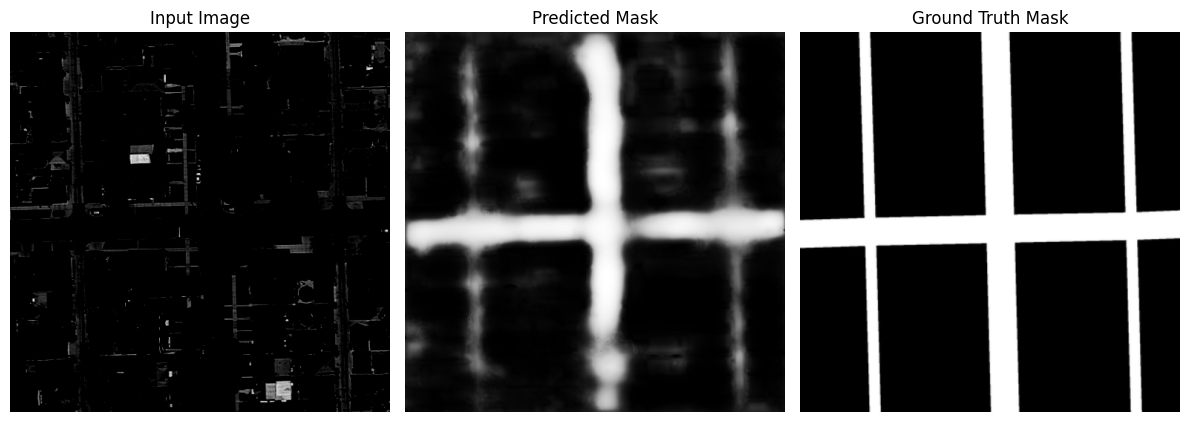

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


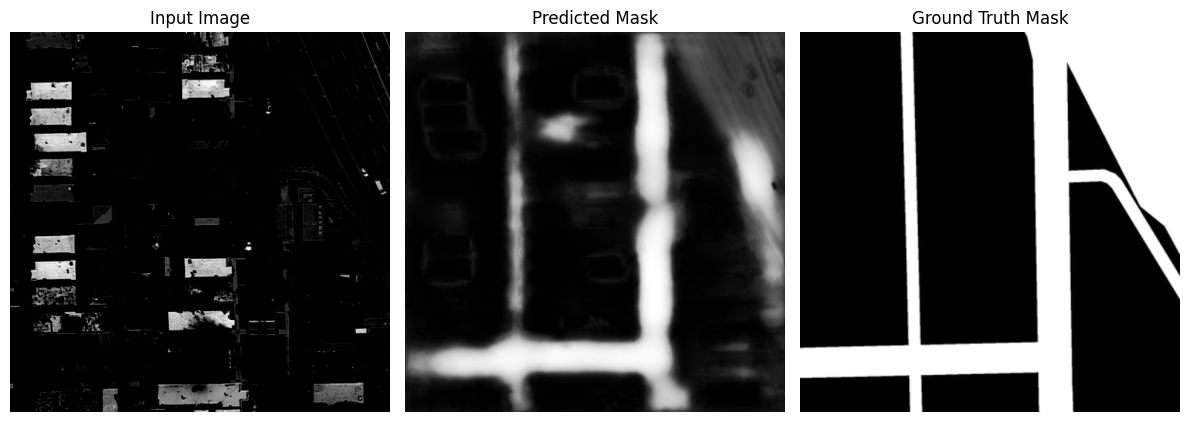

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].


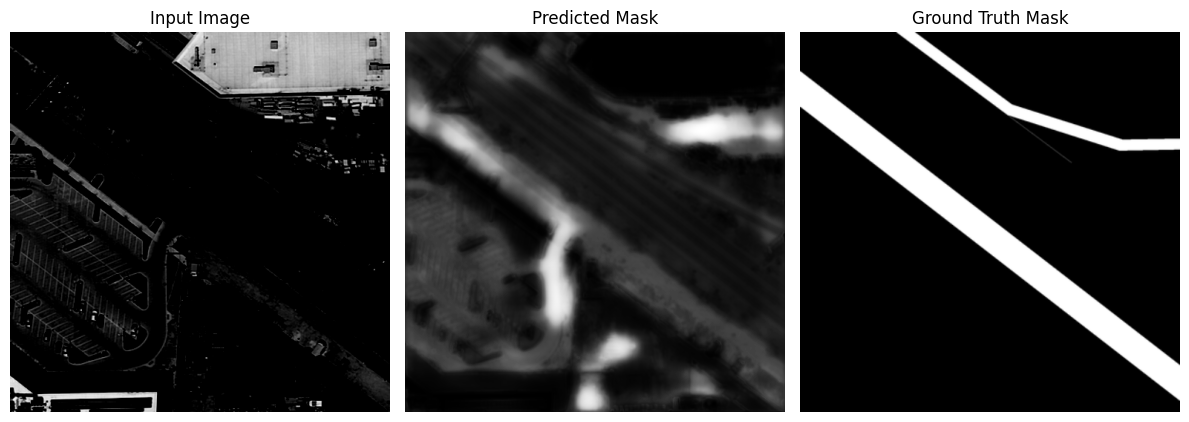

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


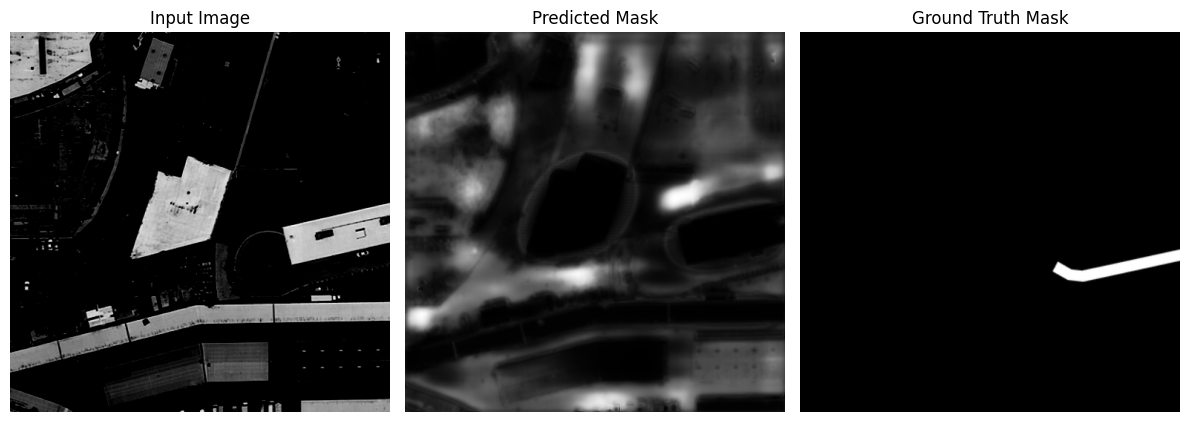

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


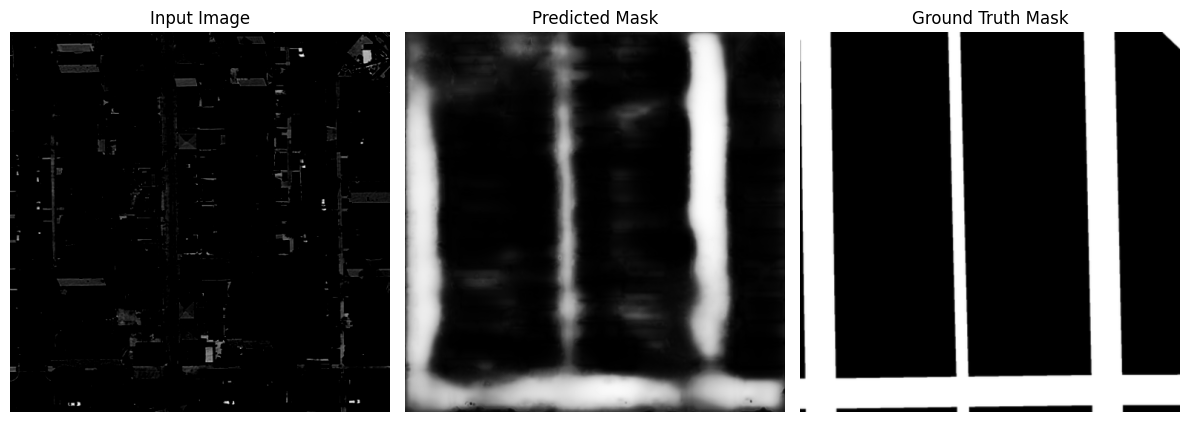

In [5]:
# Function to make a prediction and visualize
def predict_and_visualize(generator, image, ground_truth):
    """
    Predicts a mask using the generator, and visualizes the input image, predicted mask, and ground truth mask.

    Args:
        generator (nn.Module): Trained generator model.
        image (torch.Tensor): Single input image (C, H, W).
        ground_truth (torch.Tensor): Corresponding ground truth mask (1, H, W).
    """
    # Move model and image to the same device
    generator.eval()
    device = next(generator.parameters()).device
    image = image.to(device).unsqueeze(0)  # Add batch dimension
    ground_truth = ground_truth.squeeze(0).cpu().numpy()  # For visualization

    # Generate prediction
    with torch.no_grad():
        predicted_mask = generator(image)
        predicted_mask = predicted_mask.squeeze(0).squeeze(0).cpu().numpy()  # Remove batch and channel dimensions

    # Convert image to CPU for visualization
    image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Plot the input image, predicted mask, and ground truth mask
    plt.figure(figsize=(12, 6))

    # Input image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    # Predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    # Ground truth mask
    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Use a training image for prediction
count = 0
needed = 5
for images, real_masks in cell_loader:
  if count == needed:
    break
  for i in range(len(images)):
    # Select the first image and mask from the batch
    input_image = images[i]
    ground_truth_mask = real_masks[i]

    # Call the visualization function
    predict_and_visualize(generator, input_image, ground_truth_mask)
    count += 1
    if count == needed:
      break  # Use only one image
